In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import sympy as sp
import at
import math
from tqdm import tqdm

# Selfmade files
from functions import *
from PID import *

# Import ring information
from rings.p3_elements_v24_c4l import *
# ring = load_mat('rings/hmba.mat')

In [2]:
def spectrum_noise(spectrum_func, samples=1024, rate=44100):
    """ 
    make noise with a certain spectral density
    """
    freqs = np.fft.rfftfreq(samples, 1.0/rate)            # real-fft frequencies (not the negative ones)
    spectrum = np.zeros_like(freqs, dtype='complex')      # make complex numbers for spectrum
    spectrum[1:] = spectrum_func(freqs[1:])               # get spectrum amplitude for all frequencies except f=0
    phases = np.random.uniform(0, 2*np.pi, len(freqs)-1)  # random phases for all frequencies except f=0
    spectrum[1:] *= np.exp(1j*phases)                     # apply random phases
    noise = np.fft.irfft(spectrum)                        # return the reverse fourier transform
    noise = np.pad(noise, (0, samples - len(noise)), 'constant') # add zero for odd number of input samples
 
    return noise

In [3]:
# Lattice creation
lat = at.Lattice(ring, energy=6.e9)
lat.radiation_off()

# Obtaining Ids
cor_ids = at.get_refpts(lat, at.elements.Corrector)
bpm_ids = at.get_refpts(lat, at.elements.Monitor)
quad_ids = at.get_refpts(lat, at.elements.Quadrupole)

# BPMs positions
s_pos = lat.get_s_pos(bpm_ids)

Ring model:

$ y(t) = R_m \cdot \Delta q_i(t) + R_c \cdot \Delta \theta_i(t - \Delta t) $


In [4]:
dkick = 0.0001
offset = 0.0001
Rm, Rc = response_matrices(lat, dkick, offset, 1)

In [18]:
%matplotlib inline

# Time configuration 
fs = 150
ts = 1/fs
t_max = 3
t = np.arange(int(fs*t_max))/fs
N = int(fs*t_max)

# Perturbations
# perturbation_samples = spectrum_noise(lambda f: 1 / f**0, N, fs) 

# fmin=1e-3
# fmax=75
# perturbation_samples = sinesweep(t, fmin, fmax)

# fsin = 10
# amplitude = 1
# perturbation_samples = amplitude*np.sin(2*np.pi*t*fsin)

t0 = 0.1
perturbation_samples = np.piecewise(t, [t < t0, t >= t0], [0, 0.0001])

# TRANSFER FUNCTIONS
# Low pass filter 
wc = 2 * np.pi * 715
num_lp = [wc]
den_lp = [1, wc]

# PID controller
Kp = 0
Ki = 1
Kd = 0
num_pid, den_pid = PID_transfer_function(Kp, Ki, Kd)

# Simulation configuration
quad_offset = np.zeros((t.size, len(quad_ids)))
corr_str = np.zeros((t.size, len(cor_ids)))
corr_str_delay = np.zeros((t.size, len(cor_ids)))
orbit = np.zeros((t.size, len(bpm_ids)))
error = np.zeros((t.size, len(bpm_ids)))

reference_orbit = 0
rms = []
x_lp = np.zeros(len(cor_ids)*(len(den_lp)-1))
x_pid = np.zeros(len(bpm_ids)*(len(den_pid)-1))

# Delay configuration
loop_delay = 131e-3
delay_offset = math.ceil(loop_delay*fs) 

# Inverse of reponse matrix 
n_sv = 80
Rcinv = svd_solve(Rc, n_sv)

# Simulation
for n in tqdm(range(1, t.size)):
    # Error calculation
    error[n, :] = reference_orbit - orbit[n-1, :]

    # PID controller
    PID_out, x_pid = apply_f(num_pid, den_pid, error[n, :], x_pid, ts)

    # Correctors str
    corr_str[n, :] = np.dot(Rcinv.T, PID_out)

    # Apply delay
    if n >= delay_offset:
        corr_str_delay[n, :] = corr_str[n - delay_offset, :]

    # Correctors response
    filter_out, x_lp = apply_f(num_lp, den_lp, corr_str_delay[n, :], x_lp, ts)

    # Adding perturbation 
    quad_offset[n, :] = quad_offset[n, :] + perturbation_samples[n]

    # Orbit calculation
    # change_magnets_alignment(lat, perturbation_samples[n])
    # change_correctors_kick_angle(lat, filter_out)
    # out1, out2 = at.find_orbit4(lat, refpts=bpm_ids) 
    # orbit[n, :] = out2[:, 0]
    orbit[n, :] = np.dot(Rm.T, quad_offset[n, :]) + np.dot(Rc.T, filter_out)
    rms.append(np.sqrt(np.mean(np.square(orbit[n, :]))))

100%|██████████| 449/449 [03:34<00:00,  2.09it/s]


Text(0.5, 1.0, 'RMS')

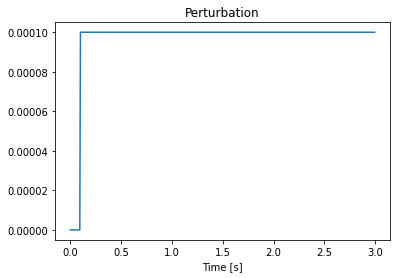

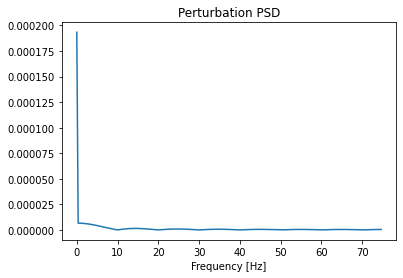

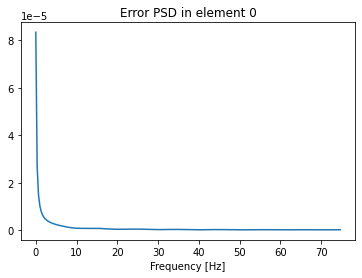

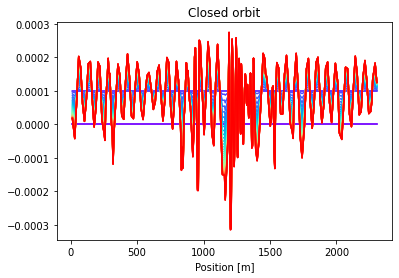

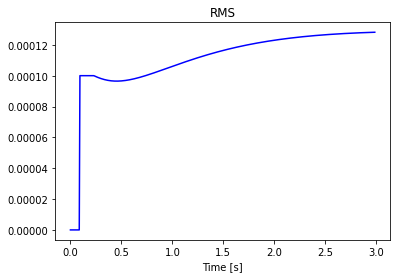

In [19]:
# Plotting
plt.plot(t, perturbation_samples[:])
plt.xlabel('Time [s]')
plt.title('Perturbation')

plt.figure()

freqs = np.fft.fftfreq(N, 1/fs)
plt.plot(freqs[:N//2], np.abs(np.fft.fft(perturbation_samples))[:N//2]*(2/len(perturbation_samples)))
plt.xlabel('Frequency [Hz]')
plt.title('Perturbation PSD')

plt.figure()

plt.plot(freqs[:N//2], np.abs(np.fft.fft(orbit[:, 0]))[:N//2]*(2/len(orbit[:, 0])))
plt.xlabel('Frequency [Hz]')
plt.title('Error PSD in element 0')

plt.figure()

color = iter(plt.cm.rainbow(np.linspace(0, 1, int(t.size/10))))
for n in range(1, t.size):
    if n%10 == 1:
        c = next(color)
        plt.plot(s_pos, orbit[n, :], c=c, label=n)
# plt.legend(loc='best')
plt.xlabel('Position [m]')
plt.title('Closed orbit')

plt.figure()

plt.plot(t[:len(t)-1], rms, 'b-')
plt.xlabel('Time [s]')
plt.title('RMS')

In [ ]:
# ts = 1/150
# wc = 2 * np.pi * 715
# num = [wc]
# den = [1, wc]
Kp = 0
Ki = 1
Kd = 0
num_pid, den_pid = PID_transfer_function(Kp, Ki, Kd)
    
sys = signal.TransferFunction(num_pid, den_pid)

w , mag, phase = signal.bode(sys)
plt.plot(w, mag)
plt.xscale('log') 
plt.figure()
plt.plot(w, phase)
plt.xscale('log') 